In [111]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
from vocabulary import Vocabulary
from parsers import load_one_file_texts
import torch

NORM_RU_VOCAB_SIZE=83400
NORM_EN_VOCAB_SIZE=28200

norm_dataset = load_one_file_texts("datasets/custom/norm_data.txt")

norm_ru_sentences, norm_en_sentences = zip(*norm_dataset)

norm_ru_vocab = Vocabulary(norm_ru_sentences, NORM_RU_VOCAB_SIZE)
norm_en_vocab = Vocabulary(norm_en_sentences, NORM_EN_VOCAB_SIZE)


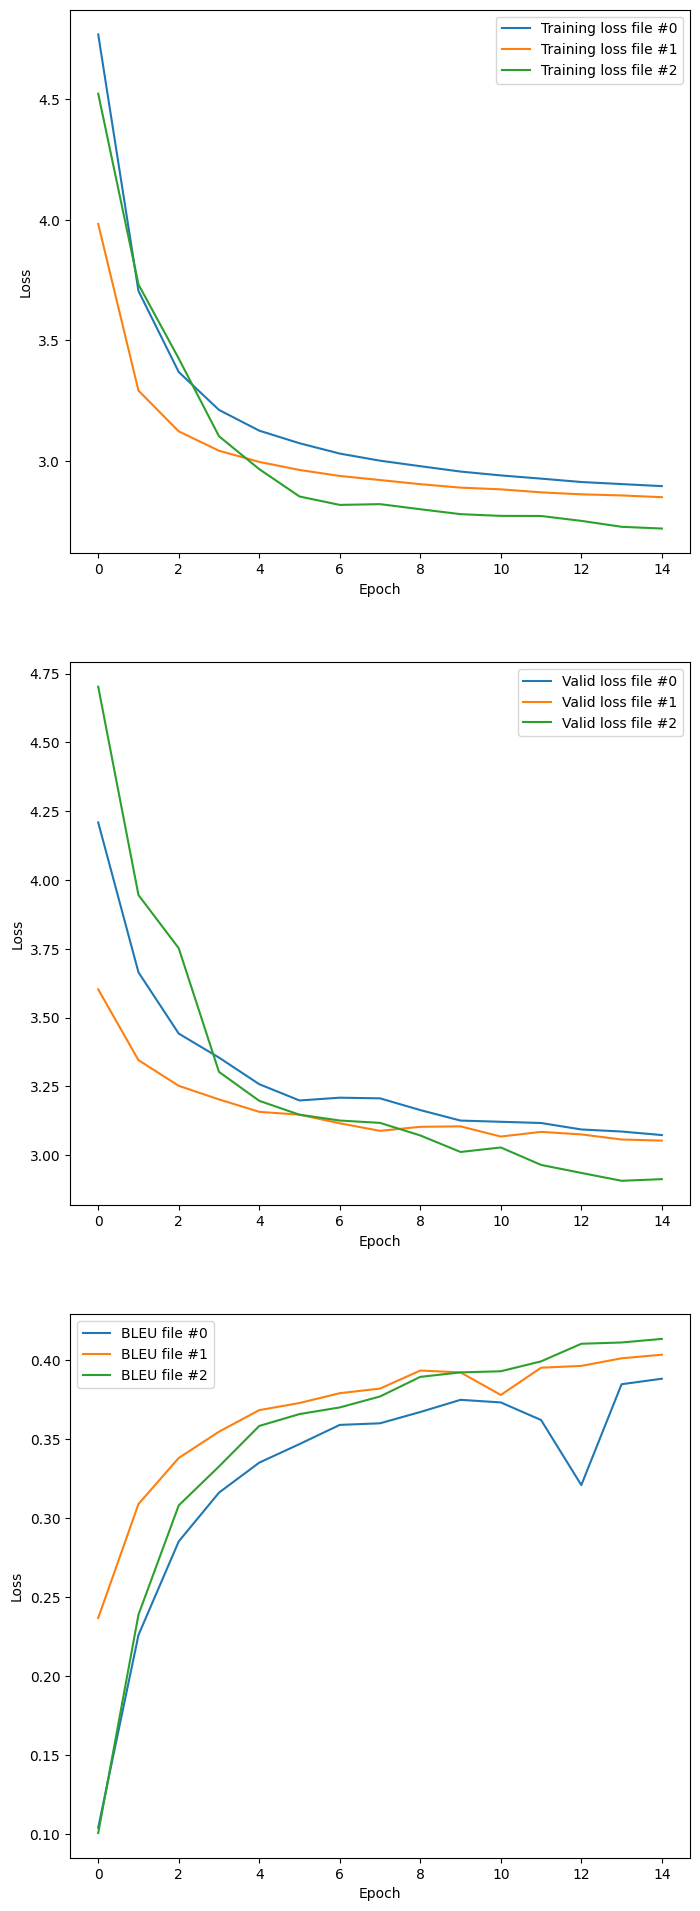

In [90]:
import matplotlib.pyplot as plt

def plot_metrics(files):
    train_losses = []
    valid_losses = []
    bleus = []
    for file_name in files:
        with open(file_name) as file:
            lines = file.readlines()
            train_losses.append([float(i) for i in lines[0].split(':')[1][2:-2].split(', ')])
            valid_losses.append([float(i) for i in lines[2].split(':')[1][2:-2].split(', ')])
            bleus.append([float(i) for i in lines[4].split(':')[1][2:-2].split(', ')])

    fig, axes = plt.subplots(3, 1, squeeze=False)
    fig.set_size_inches(8, 24)

    for i, train_loss in enumerate(train_losses):
        axes[0][0].plot(train_loss, label=f'Training loss file #{i}')
    
    for i, valid_loss in enumerate(valid_losses):
        axes[1][0].plot(valid_loss, label=f'Valid loss file #{i}')

    for i, bleu in enumerate(bleus):
        axes[2][0].plot(bleu, label=f'BLEU file #{i}')



    for i in range(3):
        axes[i][0].legend()
        axes[i][0].set_xlabel('Epoch')
        axes[i][0].set_ylabel('Loss')


plot_metrics([
    'backup/colab/model_v1_6_full_1_epoch_14.txt',
    'backup/colab/model_v1_6_easy_transfer_1_epoch_14.txt',
    'backup/colab/model_v1_6_easy_transfer_2_epoch_14.txt'
])

In [113]:
from data_norm import normolize_ru_sentence

def tranlate(model, input):
    norm_input = normolize_ru_sentence(input)
    norm_input = torch.as_tensor([norm_ru_vocab.tokenize(norm_input)])
    model.eval()
    with torch.no_grad():
        output = model(norm_input)
        output_indices = output.argmax(2)
        output = norm_en_vocab.detokenize(output_indices[0])
    return output

In [114]:
from seq2seq_model import Seq2SeqLSTM


full_model = Seq2SeqLSTM(
    input_size=NORM_RU_VOCAB_SIZE,
    output_size=NORM_EN_VOCAB_SIZE,
    embedding_decoder_dim=128,
    embedding_encoder_dim=128,
    hidden_decoder_dim=256,
    hidden_encoder_dim=256,
    num_decoder_layers=4,
    num_encoder_layers=4,
    dropout_rate=0.5
)

full_model.load_state_dict(torch.load('backup/colab/model_v1_6_full_1_epoch_14', map_location=torch.device('cpu')))

<All keys matched successfully>

In [115]:
from seq2seq_model import Seq2SeqLSTM


transfer_1_model = Seq2SeqLSTM(
    input_size=NORM_RU_VOCAB_SIZE,
    output_size=NORM_EN_VOCAB_SIZE,
    embedding_decoder_dim=128,
    embedding_encoder_dim=128,
    hidden_decoder_dim=256,
    hidden_encoder_dim=256,
    num_decoder_layers=4,
    num_encoder_layers=4,
    dropout_rate=0.5
)

transfer_1_model.load_state_dict(torch.load('backup/colab/model_v1_6_easy_transfer_1_epoch_14', map_location=torch.device('cpu')))

<All keys matched successfully>

In [116]:
transfer_2_model = Seq2SeqLSTM(
    input_size=NORM_RU_VOCAB_SIZE,
    output_size=NORM_EN_VOCAB_SIZE,
    embedding_decoder_dim=128,
    embedding_encoder_dim=128,
    hidden_decoder_dim=256,
    hidden_encoder_dim=256,
    num_decoder_layers=4,
    num_encoder_layers=4,
    dropout_rate=0.5
)

transfer_2_model.load_state_dict(torch.load('backup/colab/model_v1_6_easy_transfer_2_epoch_14', map_location=torch.device('cpu')))

<All keys matched successfully>

In [117]:


def test(models, inputs):
    for input in inputs:
        print(input)
        for model, name in models:
            output = tranlate(model, input)
            print(f'\t{name}:\t{output}')
        print()


test(
    [
        (full_model, 'full model'),
        (transfer_1_model, 'transfer 1'),
        (transfer_2_model, 'transfer 2')
    ],
    [
        'Привет, как дела?',
        'Купить новый телефон',
        'Не стоит шутить на эту тему',
        'Сколько стоит этот дом?',
        'Давайте это сделаем завтра',
        'Синий кот перебежал дорогу'
    ]
)

Привет, как дела?
	full model:	hi , how ?
	transfer 1:	hello , how are ?
	transfer 2:	hello , how is you ?

Купить новый телефон
	full model:	buy a new new .
	transfer 1:	buy to buy a new .
	transfer 2:	buy a new computer .

Не стоит шутить на эту тему
	full model:	you should n't be for that .
	transfer 1:	do n't be on this matter .
	transfer 2:	do n't be on this matter of the matter .

Сколько стоит этот дом?
	full model:	how much does this house ?
	transfer 1:	how much does this cost ?
	transfer 2:	how much does this house ?

Давайте это сделаем завтра
	full model:	let 's do that tomorrow .
	transfer 1:	let 's do that tomorrow ?
	transfer 2:	let 's do that tomorrow .

Синий кот перебежал дорогу
	full model:	the blue cat the the . .
	transfer 1:	the white cat is the the .
	transfer 2:	the black cat was the .

